In [76]:

import numpy as np
import pandas as pd
import os

# Path to where you have saved the datasets
drive_path = "C:\\Users\\"
# Load csv table
data = pd.read_csv(os.path.join(drive_path, 'scanner_data.csv'))

def add_discount_data(df):
  '''
  Creates a list of random floats 0 < x < 0.5 in particular months to mimic
  holiday promotions and discounts
  '''
  discounts = []
  for date in df.Date:
    # 'discounts' applied in summer and winter months
    if date.month in [5, 6, 7, 11, 12]:
      discounts.append(np.random.random() * 0.5)
    else:
      discounts.append(0.0)
  return discounts

# Quick data cleaning
# Set date column as datetime object
data.Date = pd.to_datetime(data.Date)
# Add simulated discount data since there was no discount data in the table
# Oops..
data['discount%'] = add_discount_data(data)
# Calculate price of each item from Sales and Quantity
data['item_price'] = data.Sales_Amount / data.Quantity
# Drop unused columns
data = data.drop('Unnamed: 0', axis=1)
data.head()


C:\Users\ryans\AppData\Local\Temp\ipykernel_7164\3431862131.py:26: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,discount%,item_price
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,0.0,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,0.0,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,0.0,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,0.0,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,0.0,6.88


In [77]:

# The variable below sets what we want to optimize; the product category or the
# product itself. Since there are fewer categories than products, computationally
# is it easier to do it for categories, but is still possible for each product.
product_grain = 'SKU_Category'

# Here we group and aggregate the transactions such that for each date and 
# product (or category) we have:
#     - Total Quantity sold
#     - Total Sales Amount
#     - Average Discount in percentage
#     - Average item price
sales_by_date_and_category = data.groupby(['Date', product_grain]).agg(
    {
        'Quantity': 'sum',
        'Sales_Amount': 'sum',
        'discount%': np.average,
        'item_price': np.average
    }
).reset_index()

# Lets bring the day and month into separate columns
sales_by_date_and_category['day'] = sales_by_date_and_category.Date.dt.day
sales_by_date_and_category['month'] = sales_by_date_and_category.Date.dt.month
sales_by_date_and_category.head()


,Date,SKU_Category,Quantity,Sales_Amount,discount%,item_price,day,month
0,2016-01-02,01F,10.0,108.76,0.0,10.449167,2,1
1,2016-01-02,0H2,11.0,71.92,0.0,6.538182,2,1
2,2016-01-02,0KX,3.0,10.76,0.0,3.565000,2,1
3,2016-01-02,0WT,4.0,16.18,0.0,3.718333,2,1
4,2016-01-02,1EO,9.0,220.80,0.0,21.910000,2,1


In [78]:

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Encode the product IDs with numbers using a dense label encoder
encoder = le.fit(sales_by_date_and_category['SKU_Category'].values)
sales_by_date_and_category[product_grain] = encoder.transform(sales_by_date_and_category[product_grain])
sales_by_date_and_category = sales_by_date_and_category.fillna(0)
sales_by_date_and_category.head()


,Date,SKU_Category,Quantity,Sales_Amount,discount%,item_price,day,month
0,2016-01-02,0,10.0,108.76,0.0,10.449167,2,1
1,2016-01-02,2,11.0,71.92,0.0,6.538182,2,1
2,2016-01-02,3,3.0,10.76,0.0,3.565000,2,1
3,2016-01-02,4,4.0,16.18,0.0,3.718333,2,1
4,2016-01-02,7,9.0,220.80,0.0,21.910000,2,1


In [79]:

# The objective of this model is to serve as a function to map the price and discount of a product to the quantity 
# sold of that product.

# Fit a regressive model to predict Quantity based on the:
#     - product
#     - discount
#     - price
#     - day
#     - month
# Using Random Forest Regressor for simplicity

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

X = sales_by_date_and_category[['SKU_Category', 'discount%', 'item_price', 'day', 'month']]
y = sales_by_date_and_category['Quantity']

rf = rf.fit(X, y)


In [80]:

# Predict Quantity on data
sales_by_date_and_category['predicted_quantity'] = rf.predict(X)

# Compute mean absolute error on predictions
sales_by_date_and_category['error'] = abs(sales_by_date_and_category.Quantity - sales_by_date_and_category.predicted_quantity)
print(f"Mean Absolute Error: {sales_by_date_and_category['error'].mean()}")


Mean Absolute Error: 1.102936736915606


In [81]:

def optimize_quantity_out(model, df, product_grain, product_grain_value, day, month):
  '''
  This function performs the optimization. Here we simple create virtual products
  with random prices and discounts and have the model predict how much quantity
  would be sold with each combination of those parameters on a given day and 
  month and product.

  For discounts % of 0 --> 70% ,
  and for prices 0.25 * mean price --> 2 * mean price:

  Q_out = model(price, discount, day, month, product)
  price_opt, discount_opt = argmax(Q_out)

  The maximum Q_out is recorded, as well as the parameters that yielded the
  prediction.
  '''

  item_price_mean = df[df[product_grain] == product_grain_value].item_price.mean()

  # get virtual prices
  potential_price = np.linspace(item_price_mean * 0.25, item_price_mean * 2, 50)
  # get virtual discounts
  potential_discount = np.linspace(0, 0.7, 20)

  # loop to create each combination of price and discount
  samples = []
  for d in potential_discount:
    for p in potential_price:
      sample = {
          product_grain: product_grain_value,
          'discount%': d,
          'item_price': p,
          'day': day,
          'month': month
      }
      samples.append(sample)

  # use trained model to predict on virtual samples
  samples = pd.DataFrame(samples)
  samples['q_out_pred'] = model.predict(samples)
  # tag optimal params
  samples['is_optimal'] = [True if s == max(samples.q_out_pred) else False for s in samples.q_out_pred]
  return samples


In [82]:

sales_by_date_and_category.SKU_Category.unique()


array([  0,   2,   3,   4,   7,   8,  10,  11,  13,  17,  18,  20,  23,
        29,  30,  33,  38,  40,  41,  43,  50,  52,  54,  55,  59,  61,
        64,  67,  68,  69,  71,  75,  76,  79,  80,  83,  85,  86,  90,
        91,  92,  94,  97,  98, 103, 104, 106, 109, 111, 113, 115, 117,
       118, 119, 121, 123, 124, 125, 127, 131, 133, 139, 140, 141, 143,
       146, 148, 150, 153, 155, 157, 158, 160, 161, 162, 164, 167, 169,
       171, 176, 180, 181, 182,  21,  31,  32,  35,  42,  44,  49,  57,
        62,  65,  95,  96, 101, 102, 126, 134, 135, 147, 151, 174, 185,
         1,  16,  28,  36,  37,  51,  60,  72,  99, 105, 108, 116, 154,
       159, 177, 186, 175,  22,  26,  53,  66,  70,  73,  87, 110, 132,
       136, 170, 137, 138, 142,   5,  48, 122, 172, 178,  78,  15,  24,
        89,  88,  74,  46,  56,  77, 107,  47,  84, 165, 183, 114, 156,
        12, 130, 168,  45, 152, 128,  93, 184, 100, 145,  25,  82, 166,
        39, 179,  34,  63, 149,   9, 120,  19,   6, 144,  27, 17

In [83]:

import random

# Here we choose the time period of our optimization
# 20th March
day = 20
month = 3

mylist = [0,2,3,4,7,8,10,11,13,17,18,20]

# Here we choose the product (or category) to optimize
sku = random.choice(mylist)

print(sku)
optimal = optimize_quantity_out(rf, sales_by_date_and_category, product_grain, sku, day, month)
optimal.head()


2


,SKU_Category,discount%,item_price,day,month,q_out_pred,is_optimal
0,2,0.0,1.608159,20,3,2.18,False
1,2,0.0,1.837896,20,3,2.25,False
2,2,0.0,2.067633,20,3,2.58,False
3,2,0.0,2.297370,20,3,2.72,False
4,2,0.0,2.527107,20,3,2.95,False


In [91]:

import plotly.express as px

# all three of these worked
fig.show(renderer='iframe')
fig.show(renderer='iframe_connected')
fig.show(renderer='colab')

plt = px.scatter_3d(optimal, x='item_price', y='discount%', z='q_out_pred', color='is_optimal')
plt.show()


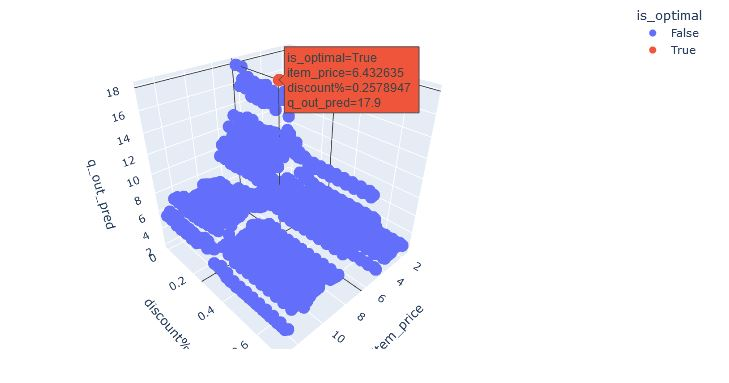

In [92]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "Capture1.JPG")


In [85]:

# concept/logic:
# https://blog.devgenius.io/how-to-build-a-dynamic-pricing-system-using-machine-learning-in-python-ad6d4e4292f8

# data:
# https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions
